# Football Events
### Write A Data Science Blog Post Project

#### Project Summary
Football Events Data comes from football games across Europe.  You are tasked with building an ETL pipeline that processes their data to answer 3 interesting questions in the first step.

The project follows the following steps:
* Step 1: Business Understanding
* Step 2: Data Understanding
* Step 3: Data Preparation
* Step 4: Answer Questions
* Step 5: Conclusion

In [66]:
# Do all imports and installs here
import pandas as pd
import re
from collections import defaultdict
import os
import glob
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.gcf().set_size_inches(20, 10)

### Step 1: Business Understanding

The scope is to create an ETL pipeline for processing, cleaning, and analyzing data related to Football Events to help answer the following interesting questions:

1) Which league had the most goals between 2011 and 2016?

2) What is the statistical distribution of goals over the country for body parts?

3) What is the best assist method for goals?

### Step 2: Data Understanding

#### Describe and Gather Data 
This Kaggle dataset from the biggest 5 European soccer leagues: England, Spain, Germany, Italy, and France, for the 2011 to 2016 seasons, contains the following pieces:

events.csv contains event data about each game.  Text commentary was scraped from: bbc.com, espn.com and onefootball.com

ginf.csv - contains metadata and market odds about each game.  Odds were collected from oddsportal.com

assist_method.csv, bodypart.csv, event_type.xlsx, event_type2.xlsx, location.csv, shot_outcome.csv, shot_place.csv, side.csv, and situation.csv contain dictionaries with the textual description of each categorical variable coded with integers

In [67]:
events = pd.read_csv('events.csv')
events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


The primary dataset is specific events from the games in chronological order, including key information like:

• id_odsp – unique identifier of game

• time – minute of the game

• event_type – primary event

• event_team – the team that produced the event

• player – name of the player involved in the main event

• shot_place – placement of the shot, 13 possible placement locations

• shot_outcome – 4 possible outcomes

• location – location on the pitch where the event happened, 19 possible locations

• is_goal – binary variable if the shot resulted in a goal (own goals included)

• And more...

In [68]:
ginf = pd.read_csv('ginf.csv')
ginf.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


The second smaller dataset includes high-level information and advanced stats with one record per game.  Key attributes are “League”, “Season”, “Country”, “Home Team”, “Away Team” and various market odds.

These two CSV datasets are transformed and joined into a single data layer for high-performance big data queries

In [69]:
joined = pd.merge(events, ginf, on='id_odsp')
joined.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN


### Step 3: Data Preparation
#### Explore the Data 
Data quality issues include some columns misssing values, which need to be filled in to avoid errors in the following steps.
#### Cleaning Steps
All missing values in any column should be handled by cleaning operations: for string, removing extra white spaces and replacing with 'NA'; for integer, replacing with 99.

In [74]:
# Performing cleaning tasks here
joined.fillna(value={'player': 'NA', 'event_team': 'NA', 'opponent': 'NA',
 'event_type': 99, 'event_type2': 99, 'shot_place': 99,
 'shot_outcome': 99, 'location': 99, 'bodypart': 99,
 'assist_method': 99, 'situation': 99})
joined.describe()

,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,is_goal,location,bodypart,...,season,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
count,941009.000000,941009.000000,941009.000000,214293.000000,941009.000000,227459.000000,228498.000000,941009.000000,467067.000000,229185.000000,...,941009.000000,941009.000000,941009.000000,941009.000000,941009.000000,941009.000000,98680.000000,98680.000000,98680.000000,98680.000000
mean,53.858826,49.663663,4.326575,12.233764,1.481170,5.733693,1.926555,0.025978,6.209073,1.624831,...,2014.405073,1.543140,1.158935,2.914901,4.243307,5.466686,2.044333,2.106117,1.938234,2.070179
std,32.014268,26.488977,2.995313,0.468850,0.499646,3.326100,0.797055,0.159071,5.421736,0.740400,...,1.594430,1.296907,1.136129,2.325088,1.833539,5.612492,0.363461,0.531667,0.211624,0.253789
min,1.000000,0.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,2012.000000,0.000000,0.000000,1.060000,1.910000,1.110000,1.140000,1.420000,1.410000,1.440000
25%,27.000000,27.000000,2.000000,12.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,...,2013.000000,1.000000,0.000000,1.770000,3.410000,2.750000,1.790000,1.790000,1.790000,1.880000
50%,53.000000,51.000000,3.000000,12.000000,1.000000,5.000000,2.000000,0.000000,3.000000,1.000000,...,2014.000000,1.000000,1.000000,2.270000,3.650000,3.860000,2.020000,1.980000,1.910000,2.050000
75%,79.000000,73.000000,8.000000,12.000000,2.000000,9.000000,3.000000,0.000000,11.000000,2.000000,...,2016.000000,2.000000,2.000000,3.050000,4.300000,5.900000,2.280000,2.260000,2.050000,2.220000
max,180.000000,100.000000,11.000000,15.000000,2.000000,13.000000,4.000000,1.000000,19.000000,3.000000,...,2017.000000,10.000000,9.000000,46.000000,35.000000,81.000000,3.400000,7.500000,3.250000,3.460000


Many fields of interest in the game events DataFrame have numeric IDs, so look-up tables are defined for mapping IDs to descriptions.

In [75]:
evtType = pd.read_excel('event_type.xlsx', header=0, index_col=0)
evtTypeMap = defaultdict(str)
for index, row in evtType.iterrows():
    evtTypeMap[int(index)] = row[0]

display(evtTypeMap)

defaultdict(str,
            {0: 'Announcement',
             1: 'Attempt',
             2: 'Corner',
             3: 'Foul',
             4: 'Yellow card',
             5: 'Second yellow card',
             6: 'Red card',
             7: 'Substitution',
             8: 'Free kick won',
             9: 'Offside',
             10: 'Hand ball',
             11: 'Penalty conceded'})

In [76]:
evtTyp2 = pd.read_excel('event_type2.xlsx', header=0, index_col=0)
evtTyp2Map = defaultdict(str)
for index, row in evtTyp2.iterrows():
    evtTyp2Map[int(index)] = row[0]

In [77]:
display(evtTyp2Map)

defaultdict(str,
            {12: 'Key Pass',
             13: 'Failed through ball',
             14: 'Sending off',
             15: 'Own goal'})

In [78]:
side = pd.read_csv('side.csv', header=0)
sideMap = defaultdict(str)
for _, row in side.iterrows():
    sideMap[int(row[0])] = row[1]

In [79]:
display(sideMap)

defaultdict(str, {1: 'Home', 2: 'Away'})

In [80]:
shotPlace = pd.read_csv('shot_place.csv', header=0)
shotPlaceMap = defaultdict(str)
for _, row in shotPlace.iterrows():
    shotPlaceMap[int(row[0])] = row[1]

In [81]:
display(shotPlaceMap)

defaultdict(str,
            {1: 'Bit too high',
             2: 'Blocked',
             3: 'Bottom left corner',
             4: 'Bottom right corner',
             5: 'Centre of the goal',
             6: 'High and wide',
             7: 'Hits the bar',
             8: 'Misses to the left',
             9: 'Misses to the right',
             10: 'Too high',
             11: 'Top centre of the goal',
             12: 'Top left corner',
             13: 'Top right corner'})

In [82]:
shotOutcome = pd.read_csv('shot_outcome.csv', header=0)
shotOutcomeMap = defaultdict(str)
for _, row in shotOutcome.iterrows():
    shotOutcomeMap[int(row[0])] = row[1]

In [83]:
display(shotOutcomeMap)

defaultdict(str,
            {1: 'On target', 2: 'Off target', 3: 'Blocked', 4: 'Hit the bar'})

In [84]:
location = pd.read_csv('location.csv', header=0)
locationMap = defaultdict(str)
for _, row in location.iterrows():
    locationMap[int(row[0])] = row[1]

In [85]:
display(locationMap)

defaultdict(str,
            {1: 'Attacking half',
             2: 'Defensive half',
             3: 'Centre of the box',
             4: 'Left wing',
             5: 'Right wing',
             6: 'Difficult angle and long range',
             7: 'Difficult angle on the left',
             8: 'Difficult angle on the right',
             9: 'Left side of the box',
             10: 'Left side of the six yard box',
             11: 'Right side of the box',
             12: 'Right side of the six yard box',
             13: 'Very close range',
             14: 'Penalty spot',
             15: 'Outside the box',
             16: 'Long range',
             17: 'More than 35 yards',
             18: 'More than 40 yards',
             19: 'Not recorded'})

In [86]:
bodyPart = pd.read_csv('bodypart.csv', header=0)
bodyPartMap = defaultdict(str)
for _, row in bodyPart.iterrows():
    bodyPartMap[int(row[0])] = row[1]

In [87]:
display(bodyPartMap)

defaultdict(str, {1: 'right foot', 2: 'left foot', 3: 'head'})

In [88]:
assistMethod = pd.read_csv('assist_method.csv', header=0)
assistMethodMap = defaultdict(str)
for _, row in assistMethod.iterrows():
    assistMethodMap[int(row[0])] = row[1]

In [89]:
display(assistMethodMap)

defaultdict(str,
            {0: 'None',
             1: 'Pass',
             2: 'Cross',
             3: 'Headed pass',
             4: 'Through ball'})

In [90]:
situation = pd.read_csv('situation.csv', header=0)
situationMap = defaultdict(str)
for _, row in situation.iterrows():
    situationMap[int(row[0])] = row[1]

In [91]:
display(situationMap)

defaultdict(str, {1: 'Open play', 2: 'Set piece', 3: 'Corner', 4: 'Free kick'})

### Step 4: Answer Questions

#### 4.1 What is the distribution of goals by countries/leagues?

In [94]:
countries = pd.DataFrame(joined.groupby(['country'])['is_goal'].sum().reset_index())
countries

,country,is_goal
0,england,3552
1,france,5199
2,germany,4621
3,italy,5491
4,spain,5583


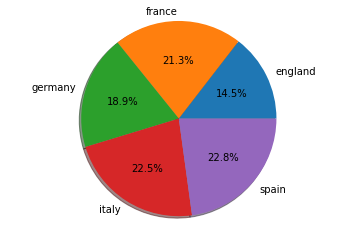

In [95]:
def pie_chart(x, labels):
    """
    This function takes in data and outputs a pie chart
    
    Parameters:
    x(array-like): the array to make a pie chart
    labels(list): a sequence of strings providing the labels for each wedge
    """
    fig, ax = plt.subplots()
    ax.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    ax.axis('equal')
    plt.show()
pie_chart(countries['is_goal'], countries['country'])

Spanish league has had most goals over the term of this data.

#### 4.2 What is the distribution of goals over the country for body parts?

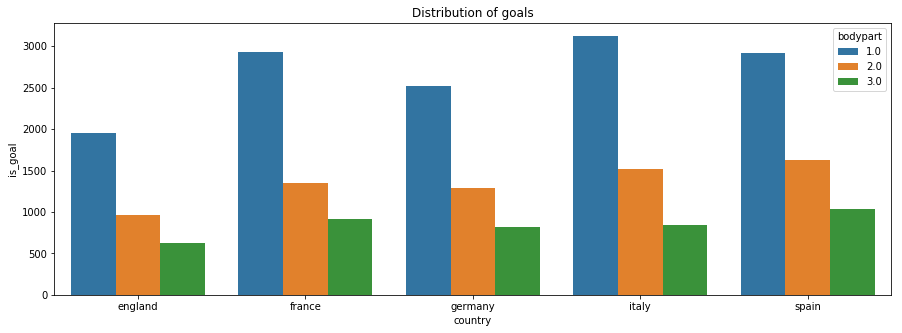

In [106]:
goals = pd.DataFrame(joined.groupby(['country', 'bodypart'])['is_goal'].sum().reset_index())
plt.figure(figsize=(15,5))
plt.title('Distribution of goals')
sns.barplot(x='country',y='is_goal',hue='bodypart',data=goals)

#### 4.3 What is the distribution of goals by assist methods?

In [100]:
assistMethods = pd.DataFrame(joined.groupby(['assist_method'])['is_goal'].sum().reset_index())
assistMethods

,assist_method,is_goal
0,0,7877
1,1,8662
2,2,5143
3,3,844
4,4,1920


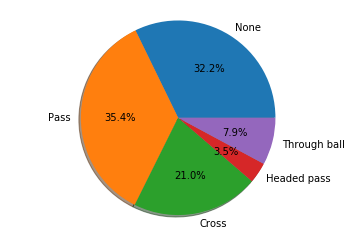

In [102]:
# fig, ax = plt.subplots()
# ax.pie(assistMethods['is_goal'], labels=assistMethodMap.values(), autopct='%1.1f%%', shadow=True)
# ax.axis('equal')
# plt.show()
pie_chart(assistMethods['is_goal'], assistMethodMap.values())

#### Step 5: Conclusion
* Spanish league is observed to have most goals over the term of this data.

* To find the top goal body part from the games in all countries, three catogeries are shown side by side.

* Pie-chart is used to see the distribution of goals by assist method: the best way is through Pass.